<a href="https://colab.research.google.com/github/CodeHunterOfficial/ABC_DataMining/blob/main/DevOps/GitHub_CI_CD_%D1%81_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E_GitHub_Actions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подробное руководство: Создание ASP.NET Core проекта и настройка CI/CD с GitHub Actions

## Оглавление
1. [Подготовка среды разработки](#подготовка-среды)
2. [Создание ASP.NET Core проекта](#создание-проекта)
3. [Настройка проекта и тестирование](#настройка-проекта)
4. [Создание репозитория на GitHub](#создание-репозитория)
5. [Настройка GitHub Actions для CI](#настройка-ci)
6. [Настройка CD для деплоя](#настройка-cd)
7. [Тестирование всего пайплайна](#тестирование-пайплайна)



## <a name="подготовка-среды"></a>1. Подготовка среды разработки

### Установка необходимого ПО

**1. Установите .NET SDK:**
- Перейдите на [официальный сайт .NET](https://dotnet.microsoft.com/download)
- Скачайте и установите последнюю версию .NET SDK (8.0 или новее)
- Проверьте установку в терминале:
```bash
dotnet --version
```

**2. Установите Visual Studio Code:**
- Скачайте с [официального сайта](https://code.visualstudio.com/)
- Установите расширения для C# разработки:
  - C# (от Microsoft)
  - NuGet Package Manager
  - .NET Core Test Explorer

**3. Установите Git:**
- Скачайте с [git-scm.com](https://git-scm.com/)
- Настройте глобально:
```bash
git config --global user.name "Ваше Имя"
git config --global user.email "ваш.email@example.com"
```






## <a name="создание-проекта"></a>2. Создание ASP.NET Core проекта

### Шаг 1: Создание папки проекта
```bash
mkdir MyAspNetCoreApp
cd MyAspNetCoreApp
```


### Шаг 2: Создание нового проекта
```bash
dotnet new webapi -n MyWebApi --framework net8.0
cd MyWebApi
```


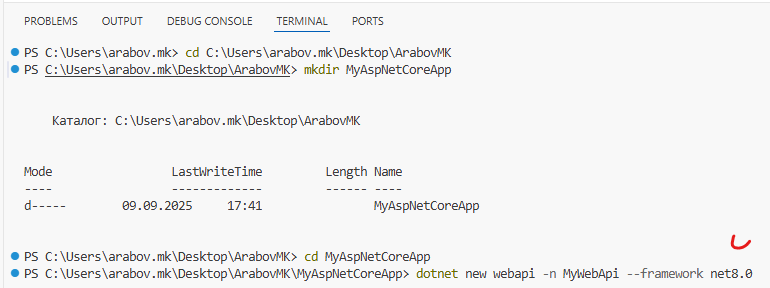


### Шаг 3: Проверка структуры проекта
```bash
tree /F
```
Должны увидеть:


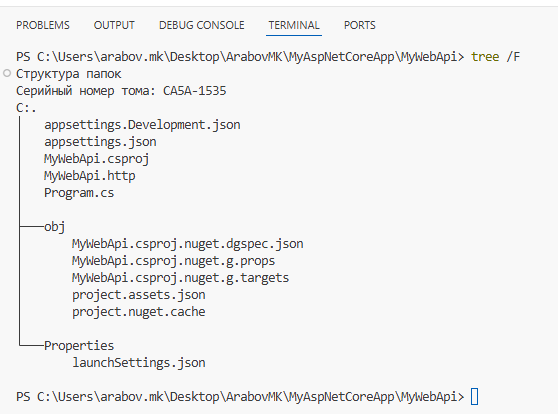

Открыть проект

```bash
code ..
```

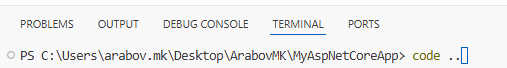


### Шаг 4: Тестовый запуск
```bash
dotnet run
```
Откройте браузер и перейдите по `http://localhost:5000/weatherforecast`




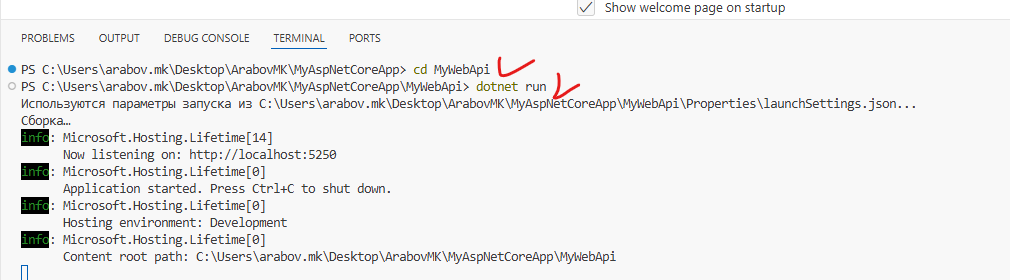


## <a name="настройка-проекта"></a>3. Настройка проекта и тестирование

### Шаг 1: Добавление тестового проекта
```bash
# В корневой папке (рядом с MyWebApi)
dotnet new xunit -n MyWebApi.Tests
cd MyWebApi.Tests
dotnet add reference ../MyWebApi/MyWebApi.csproj
```

### Шаг 2: Создание простого теста
Откройте `UnitTest1.cs` в тестовом проекте и замените содержимое:

```csharp
using Microsoft.AspNetCore.Mvc.Testing;
using System.Net;
using Xunit;

namespace MyWebApi.Tests
{
    public class UnitTest1 : IClassFixture<WebApplicationFactory<Program>>
    {
        private readonly WebApplicationFactory<Program> _factory;

        public UnitTest1(WebApplicationFactory<Program> factory)
        {
            _factory = factory;
        }

        [Fact]
        public async Task GetWeatherForecast_ReturnsSuccess()
        {
            // Arrange
            var client = _factory.CreateClient();

            // Act
            var response = await client.GetAsync("/weatherforecast");

            // Assert
            response.EnsureSuccessStatusCode();
            Assert.Equal(HttpStatusCode.OK, response.StatusCode);
        }
    }
}
```

### Шаг 3: Добавление файла решения
```bash
# В корневой папке
dotnet new sln -n MyAspNetCoreSolution
dotnet sln add MyWebApi/MyWebApi.csproj
dotnet sln add MyWebApi.Tests/MyWebApi.Tests.csproj
```

### Шаг 4: Локальное тестирование
```bash
dotnet test
```
Убедитесь, что все тесты проходят.

---

## <a name="создание-репозитория"></a>4. Создание репозитория на GitHub

### Шаг 1: Инициализация Git
```bash
# В корневой папке решения
git init
```

### Шаг 2: Создание .gitignore
Создайте файл `.gitignore` с содержимым:
```
**/bin/
**/obj/
*.user
*.suo
*.vscode/
*.vs/
*.swp
*.cache
.DS_Store
*.pyc
.nuget/
packages/
appsettings.Development.json
```

### Шаг 3: Первый коммит
```bash
git add .
git commit -m "Initial commit: ASP.NET Core Web API project"
```

### Шаг 4: Создание репозитория на GitHub
1. Зайдите на [GitHub.com](https://github.com)
2. Нажмите "New repository"
3. Имя: `MyAspNetCoreApp`
4. Описание: "ASP.NET Core Web API with CI/CD"
5. Не добавляйте README, .gitignore или license (мы уже создали .gitignore)

### Шаг 5: Привязка и пуш
```bash
git remote add origin https://github.com/ваш-username/MyAspNetCoreApp.git
git branch -M main
git push -u origin main
```

---

## <a name="настройка-ci"></a>5. Настройка GitHub Actions для CI

### Шаг 1: Создание директории для workflows
```bash
mkdir -p .github/workflows
```

### Шаг 2: Создание файла CI pipeline
Создайте файл `.github/workflows/dotnet-ci.yml`:

```yaml
name: .NET CI Pipeline

on:
  push:
    branches: [ "main", "develop" ]
  pull_request:
    branches: [ "main" ]

env:
  DOTNET_VERSION: '8.0.x'
  PROJECT_PATH: 'MyWebApi/MyWebApi.csproj'
  TEST_PATH: 'MyWebApi.Tests/MyWebApi.Tests.csproj'

jobs:
  build:
    runs-on: ubuntu-latest

    steps:
    - name: Checkout code
      uses: actions/checkout@v4

    - name: Setup .NET Core
      uses: actions/setup-dotnet@v3
      with:
        dotnet-version: ${{ env.DOTNET_VERSION }}

    - name: Restore dependencies
      run: dotnet restore

    - name: Build solution
      run: dotnet build --configuration Release --no-restore

    - name: Run tests
      run: dotnet test --configuration Release --no-build --verbosity normal

    - name: Publish application
      run: dotnet publish ${{ env.PROJECT_PATH }} -c Release -o ./publish

    - name: Upload build artifacts
      uses: actions/upload-artifact@v3
      with:
        name: published-app
        path: ./publish
```

### Шаг 3: Коммит и пуш CI конфигурации
```bash
git add .github/workflows/dotnet-ci.yml
git commit -m "Add CI pipeline with build, test and publish"
git push origin main
```

### Шаг 4: Проверка workflow
1. Перейдите на GitHub в ваш репозиторий
2. Откройте вкладку "Actions"
3. Убедитесь, что workflow запустился и завершился успешно

---

## <a name="настройка-cd"></a>6. Настройка CD для деплоя

### Вариант 1: Деплой на GitHub Pages (для статики) + Heroku

### Шаг 1: Подготовка к деплою
Добавьте в `Program.cs` поддержку статических файлов:

```csharp
var builder = WebApplication.CreateBuilder(args);

// Добавьте сервисы
builder.Services.AddControllers();
builder.Services.AddEndpointsApiExplorer();
builder.Services.AddSwaggerGen();

var app = builder.Build();

// Configure the HTTP request pipeline.
if (app.Environment.IsDevelopment())
{
    app.UseSwagger();
    app.UseSwaggerUI();
}

app.UseHttpsRedirection();
app.UseAuthorization();
app.MapControllers();

// Serve static files for frontend (if needed)
app.UseDefaultFiles();
app.UseStaticFiles();

app.Run();
```

### Шаг 2: Создание CD pipeline
Создайте файл `.github/workflows/dotnet-cd.yml`:

```yaml
name: .NET CD Pipeline

on:
  workflow_run:
    workflows: [".NET CI Pipeline"]
    types:
      - completed
  workflow_dispatch:  # Allow manual trigger

env:
  DOTNET_VERSION: '8.0.x'
  PROJECT_PATH: 'MyWebApi/MyWebApi.csproj'

jobs:
  deploy:
    if: ${{ github.event.workflow_run.conclusion == 'success' }}
    runs-on: ubuntu-latest
    environment: production

    steps:
    - name: Checkout code
      uses: actions/checkout@v4

    - name: Setup .NET Core
      uses: actions/setup-dotnet@v3
      with:
        dotnet-version: ${{ env.DOTNET_VERSION }}

    - name: Download build artifacts from CI
      uses: actions/download-artifact@v3
      with:
        name: published-app
        path: ./publish

    - name: List published files
      run: ls -la ./publish

    - name: Create deployment package
      run: |
        tar -czf deploy.tar.gz -C ./publish .

    - name: Upload deployment package
      uses: actions/upload-artifact@v3
      with:
        name: deployment-package
        path: deploy.tar.gz

    - name: Notify success
      run: echo "Deployment package created successfully!"
```

### Вариант 2: Деплой на Heroku (реальный хостинг)

### Шаг 1: Создание аккаунта Heroku
1. Зарегистрируйтесь на [heroku.com](https://heroku.com)
2. Создайте новое приложение в dashboard

### Шаг 2: Добавление секретов в GitHub
1. В репозитории GitHub: Settings → Secrets and variables → Actions
2. Добавьте:
   - `HEROKU_API_KEY`: ваш API ключ из Heroku account settings
   - `HEROKU_APP_NAME`: имя вашего Heroku приложения

### Шаг 3: Обновление CD pipeline для Heroku
Замените содержимое `dotnet-cd.yml`:

```yaml
name: .NET CD to Heroku

on:
  workflow_run:
    workflows: [".NET CI Pipeline"]
    types:
      - completed
  workflow_dispatch:

env:
  HEROKU_APP_NAME: ${{ secrets.HEROKU_APP_NAME }}

jobs:
  deploy:
    if: ${{ github.event.workflow_run.conclusion == 'success' }}
    runs-on: ubuntu-latest
    environment: production

    steps:
    - name: Checkout code
      uses: actions/checkout@v4

    - name: Download build artifacts
      uses: actions/download-artifact@v3
      with:
        name: published-app
        path: ./publish

    - name: Create Procfile for Heroku
      run: echo "web: ./MyWebApi --urls http://+:$$PORT" > ./publish/Procfile

    - name: Deploy to Heroku
      uses: akhileshns/heroku-deploy@v3.12.12
      with:
        heroku_api_key: ${{ secrets.HEROKU_API_KEY }}
        heroku_app_name: ${{ secrets.HEROKU_APP_NAME }}
        heroku_email: "ваш.email@example.com"
        appdir: "./publish"
        procfile: "web: ./MyWebApi --urls http://+:$PORT"
        usedocker: false

    - name: Verify deployment
      run: |
        echo "Checking deployment status..."
        sleep 10
        curl -f https://${{ secrets.HEROKU_APP_NAME }}.herokuapp.com/weatherforecast || echo "Deployment might still be starting"

    - name: Send notification
      run: echo "Application deployed successfully to Heroku!"
```

### Шаг 4: Коммит и пуш CD конфигурации
```bash
git add .github/workflows/dotnet-cd.yml
git commit -m "Add CD pipeline for Heroku deployment"
git push origin main
```

---

## <a name="тестирование-пайплайна"></a>7. Тестирование всего пайплайна

### Шаг 1: Внесение изменений для тестирования
Добавьте новый endpoint в `Controllers/WeatherForecastController.cs`:

```csharp
[HttpGet("hello")]
public IActionResult GetHello()
{
    return Ok(new { message = "Hello from CI/CD Pipeline!" });
}
```

### Шаг 2: Добавление теста для нового endpoint
В `MyWebApi.Tests/UnitTest1.cs` добавьте:

```csharp
[Fact]
public async Task GetHello_ReturnsMessage()
{
    // Arrange
    var client = _factory.CreateClient();

    // Act
    var response = await client.GetAsync("/weatherforecast/hello");
    var content = await response.Content.ReadAsStringAsync();

    // Assert
    response.EnsureSuccessStatusCode();
    Assert.Contains("Hello from CI/CD Pipeline", content);
}
```

### Шаг 3: Запуск пайплайна
```bash
git add .
git commit -m "Add new hello endpoint and test"
git push origin main
```

### Шаг 4: Мониторинг процесса
1. Перейдите на GitHub → ваш репозиторий → Actions
2. Наблюдайте за выполнением CI pipeline
3. После успеха CI автоматически запустится CD pipeline
4. Проверьте деплой на Heroku: `https://your-app-name.herokuapp.com/weatherforecast/hello`

### Шаг 5: Проверка результатов
Убедитесь, что:
- ✅ Все тесты проходят
- ✅ Сборка успешна
- ✅ Деплой выполнен
- ✅ Новый endpoint работает

---

## Решение возможных проблем

### Проблема 1: Ошибки зависимостей
**Решение:** Убедитесь, что версии .NET совпадают локально и в workflow

### Проблема 2: Ошибки деплоя на Heroku
**Решение:** Проверьте:
- Правильность имени приложения Heroku
- Корректность API ключа
- Наличие Procfile

### Проблема 3: Тесты не запускаются
**Решение:** Добавьте явное указание на test project:
```yaml
- name: Run tests
  run: dotnet test ${{ env.TEST_PATH }} --configuration Release --no-build
```

## Дополнительные улучшения

1. **Добавьте качество кода:**
```yaml
- name: Run linting
  run: dotnet format --verify-no-changes --verbosity detailed
```

2. **Добавьте security scanning:**
```yaml
- name: Security scan
  uses: github/codeql-action/init@v2
  with:
    languages: csharp
```

3. **Добавьте уведомления:**
```yaml
- name: Send Slack notification
  uses: 8398a7/action-slack@v3
  with:
    status: ${{ job.status }}
    channel: '#deployments'
```

Теперь у вас есть полноценный CI/CD пайплайн для ASP.NET Core приложения! 🎉